In [5]:
import os
import torch
import datetime
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from monai.config import print_config
from monai.inferers import sliding_window_inference
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.utils import first

from monai.data import (
    Dataset,
    DataLoader,
    CacheDataset,
    decollate_batch,
)


from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    RandSpatialCropd,
    ScaleIntensityd,
    SpatialPadd,
    ToTensord,
)

print_config()

MONAI version: 0.9.dev2220
Numpy version: 1.22.4
Pytorch version: 1.11.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 1e9b0084b1d32b4a72f6e309bacde1390526d38f
MONAI __file__: /home/bmegpu01/anaconda3/envs/wjin/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.2
scikit-image version: 0.19.2
Pillow version: 9.2.0
Tensorboard version: 2.10.1
gdown version: 4.4.0
TorchVision version: 0.12.0
tqdm version: 4.64.1
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.5.1
einops version: 0.4.1
transformers version: 4.19.1
mlflow version: 1.26.0
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [6]:
# Define transforms

train_transforms = Compose(
    [
        LoadImaged(keys=["image1","image2", "seg"]),
        
        ScaleIntensityd(
            keys=["image1","image2"],
            minv=0.0,
            maxv=1.0,
        ),
        SpatialPadd(
            keys=["image1","image2","seg"],
            spatial_size = (96, 320, 80),        
        ),
        RandSpatialCropd(
            keys=["image1","image2","seg"],
            roi_size = (96, 256, 64),
            random_size=False,
        ),
        
        ToTensord(keys=["image1","image2", "seg"]),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image1","image2", "seg"]),
        
        ScaleIntensityd(
            keys=["image1","image2"],
            minv=0.0,
            maxv=1.0,
        ),  
        
        ToTensord(keys=["image1","image2", "seg"]),
    ]
)

In [7]:
path = "./Data/Ingenia"
flist = os.listdir(path)
folder_list = [file for file in flist if not file.endswith(".ipynb_checkpoints")]

train_ind = np.arange(0,135) #135
val_ind = np.arange(135,169) #34

In [8]:
data_dicts = [
    {
        "image1": os.path.join(path,folder_list[idx],
                                    "GREM.nii.gz"),
        "image2": os.path.join(path,folder_list[idx],
                                    "UP.nii.gz"),
        "seg": os.path.join(path,folder_list[idx],
                                    "dlseg_sss_wjin.nii.gz"),
    }
    for idx in train_ind
]

vdata_dicts = [
    {
        "image1": os.path.join("data","ingenia_no_last_dim",folder_list[idx],
                                    "GREM.nii.gz"),
        "image2": os.path.join("data","ingenia_no_last_dim",folder_list[idx],
                                    "UP.nii.gz"),
        "seg": os.path.join("data","ingenia_no_last_dim",folder_list[idx],
                                    "dlseg_sss_v1_0.nii.gz"),
    }
    for idx in val_ind
]

train_Data =  data_dicts
valid_Data =  vdata_dicts

In [9]:
train_ds = CacheDataset(
    data=train_Data,
    transform=train_transforms,
    cache_num=4,
    cache_rate=1.0,
    num_workers=0,
)

train_loader = DataLoader(
    train_ds,
    batch_size=8,
    shuffle=True,
    num_workers=8,
    pin_memory=True
)

val_ds = CacheDataset(
    data=train_Data,
    transform=val_transforms,
    cache_num=4,
    cache_rate=1.0,
    num_workers=4
)

val_loader = DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

image1 shape: torch.Size([1, 512, 512, 80]), image2 shape: torch.Size([1, 512, 512, 80]), label: torch.Size([1, 512, 512, 80])


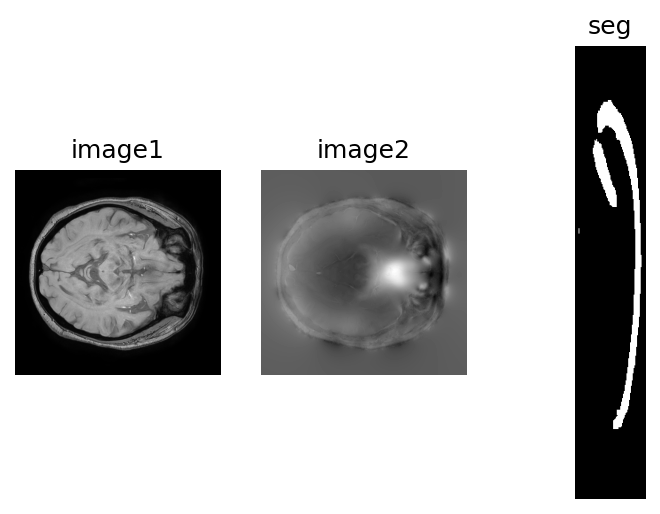

In [17]:
check_ds = Dataset(data= data_dicts, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1, shuffle = True)
check_data = first(check_loader)

image1, image2, label = (check_data["image1"][0], check_data["image2"][0], check_data["seg"][0])
print(f"image1 shape: {image1.shape}, image2 shape: {image2.shape}, label: {label.shape}")

plt.figure(dpi = 150)

plt.subplot(1, 3, 1)
plt.title("image1")
plt.imshow(image1[0, :, :, 32], cmap="gray")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("image2")
plt.imshow(image2[0, :, :, 32], cmap="gray")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("seg")
plt.imshow(torch.amax(label[0, :, :, :], 0), cmap="gray")
plt.axis('off')

plt.show()

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [19]:
def show_result(val_labels, val_outputs, global_step, fd_name):
        plt.figure(2,figsize=(24,16))
        plt.subplot(131)
        plt.imshow(torch.amax(val_outputs[0,1,:,:,:],dim=2).cpu())
        plt.title('prediction')
        plt.subplot(132)
        plt.imshow(torch.amax(val_outputs[0,1,:,:,:]>.5,dim=2).cpu())
        plt.title('prediction > 0.5')
        plt.subplot(133)
        plt.imshow(torch.amax(val_labels[0,0,:,:,:],dim=2).cpu())
        plt.title('label')
        tmpa = datetime.datetime.now().date()
        plt.savefig(f'result/{fd_name}/progress/{tmpa}_step_{global_step}.png')
        plt.close(2)

In [25]:
def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (torch.cat((batch["image1"],batch["image2"]),dim=1).to(device), batch["seg"].to(device))
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            
            dice_val, val_labels, val_outputs = validation(epoch_iterator_val)
            
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
              
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(f"result/{fd_name}/best_metric_model.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )

        
        else:
            print(
                "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                    dice_val_best, dice_val
                )
            )
        
        global_step += 1
        show_result(val_labels, val_outputs, global_step, fd_name)

            
    return global_step, dice_val_best, global_step_best

In [19]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (torch.cat((batch["image1"],batch["image2"]), dim=1).to(device), batch["seg"].to(device))
            val_outputs = sliding_window_inference(val_inputs, (96, 256, 64), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list

            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        mean_dice_val = np.mean(dice_vals)
        dice_metric.reset()
        
    return mean_dice_val, val_labels, val_outputs

In [20]:
def show_result(val_labels, val_outputs, global_step, fd_name):
        plt.figure(2,figsize=(24,16))
        plt.subplot(131)
        plt.imshow(torch.amax(val_outputs[0,1,:,:,:],dim=2).cpu())
        plt.title('prediction')
        plt.subplot(132)
        plt.imshow(torch.amax(val_outputs[0,1,:,:,:]>.5,dim=2).cpu())
        plt.title('prediction > 0.5')
        plt.subplot(133)
        plt.imshow(torch.amax(val_labels[0,0,:,:,:],dim=2).cpu())
        plt.title('label')
        tmpa = datetime.datetime.now().date()
        plt.savefig(f'result/{fd_name}/progress/{tmpa}_step_{global_step}.png')
        plt.close(2)

In [27]:
#Notice!!
fd_name = 'AdamW-2'

In [28]:
#%%writefile result/{fd_name}/README.txt

model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=8,
    in_channels=2,
    out_channels=2,
    dropout_prob=0.2,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [29]:
post_label = AsDiscrete(to_onehot=2)
post_pred = AsDiscrete(argmax=True, to_onehot=2)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

In [30]:
max_iterations = 2500
eval_num = 10

In [31]:
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )

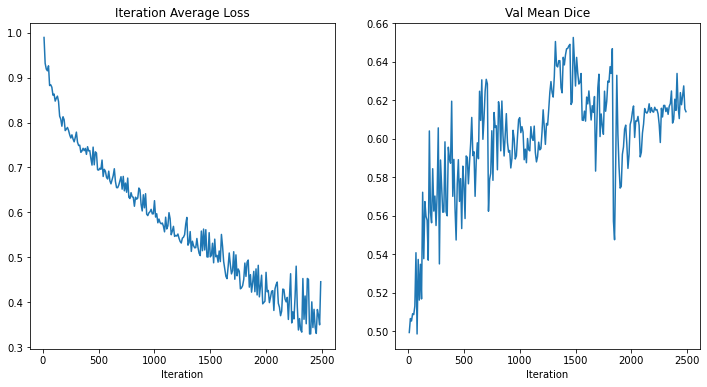

In [32]:
plt.figure("train", (12, 6))

plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)

plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

#plt.savefig(f'result/{fd_name}/show_result/loss_and_dice.png')

In [34]:
model.eval()
with torch.no_grad():
    for step, batch in enumerate(val_loader):
        val_inputs, val_labels = (torch.cat((batch["image1"],batch["image2"]),dim=1).cuda(), batch["seg"].cuda())
        val_outputs = sliding_window_inference(val_inputs, (96,256, 64), 4, model,mode="gaussian",overlap=0.5)

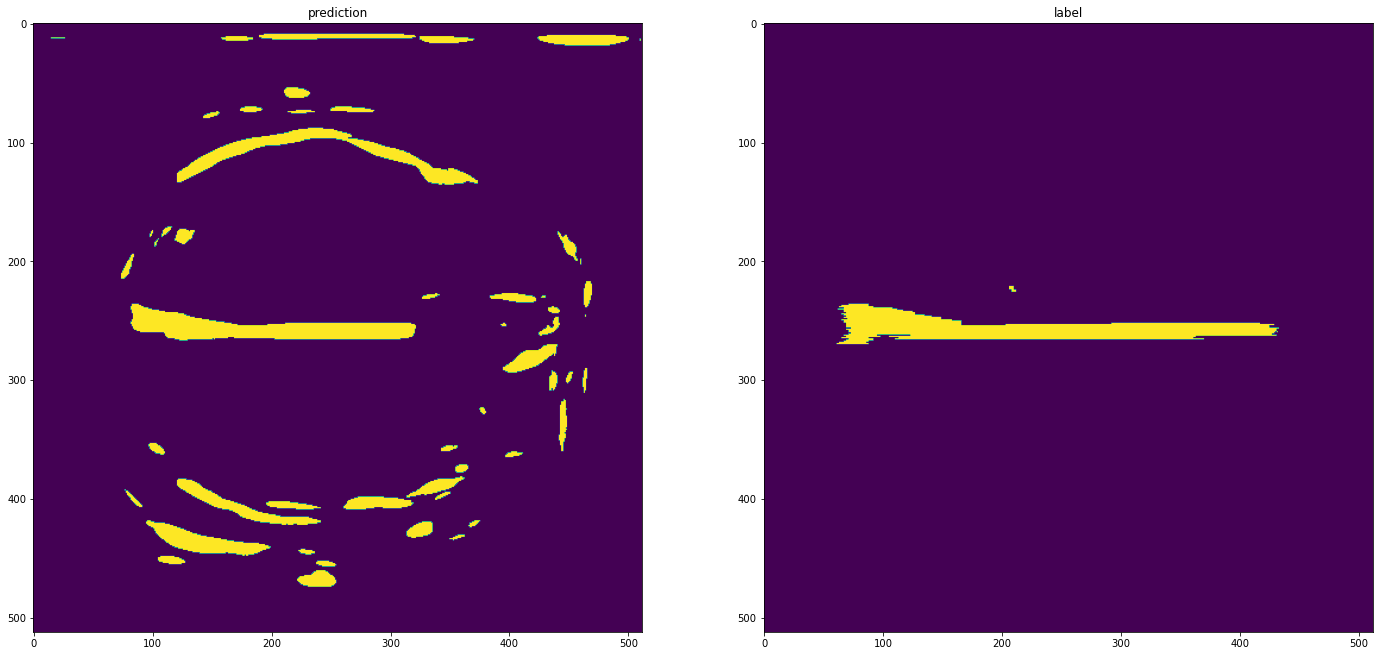

In [39]:
plt.figure(2,figsize=(24,16))

plt.subplot(121)
plt.imshow(torch.amax(val_outputs[0,1,:,:,:]>.5,dim=2).cpu())
plt.title('prediction')
        
plt.subplot(122)
plt.imshow(torch.amax(val_labels[0,0,:,:,:]>.5,dim=2).cpu())
plt.title('label')

plt.show()